In [1]:
# import packages
import scipy
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam, lr_scheduler

from IPython.display import display, Math, Latex

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from tqdm import tqdm, trange
import pandas as pd
import ot

import functions as func
import diffusion as diff
import synthetic_data as synt

import seaborn as sns
sns.set_theme()
import pickle
import time

import sampler as sp
import decoder
from functions import empirical, kl_divergence, kl, wasserstein_w2, w2
from upperbounds import gaussian
import upperbounds as up

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#devices and generator seeds

device_cuda = torch.device("cuda:0")
device_cpu = torch.device("cpu")

if torch.cuda.is_available() and torch.backends.cuda.is_built():
    print("Utilisation du GPU")
    device = device_cuda
else:
    print("Utilisation du CPU")
    device = device_cpu
device = torch.device("cpu")

#seed = torch.random.seed()
#print("seed:", seed)
seed = 20
np.random.seed(seed)
torch.manual_seed(seed)

Utilisation du CPU


In [4]:
########### SET Training data PARAMETERS #################
n = 10000 
d = 5
mu = torch.ones(d, device = device)

### Isotropic case
#scale_var = .5
#SIGMA = torch.eye(d,device = device) * scale_var

### Heteroscedastic case
#blocks = torch.tensor([1, .01, 1., 1., 1.], device=device)
#diag_values = torch.repeat_interleave(blocks, d // len(blocks))
#SIGMA = torch.diag(diag_values)

### Correlated case
SIGMA = torch.eye(d, device=device)
for i in range(d):
    for j in range(d):
        if i != j:
            SIGMA[i, j] = 1 / np.sqrt(np.abs(j-i)+1)


training_distribution = gaussian(d, mu, SIGMA)
training_sample = training_distribution.generate_sample(n)

### Funnel distribution
#training_distribution = synt.Funnel(d)
#training_sample = training_distribution.sample(n)

### MG25 
#training_distribution = synt.MG25(d)
#training_sample = MG25_distribution.sample(n)

In [5]:
########### SET DIFFUSION AND NOISING PARAMETERS #################
sigma_inv = 1
beta_min = 0.1
beta_max = 20
a = torch.tensor(0.)
T = 1

# Set noising function and parameters
a_values = np.linspace(-10.,10.,21) #set the parameter values for the beta_parametric function
beta = diff.beta_parametric(a, T, beta_min, beta_max)
#beta = diff.beta_cosine(T, 0.021122)

sde = diff.forward_VPSDE(d, beta, sigma_inv, T, device = device)

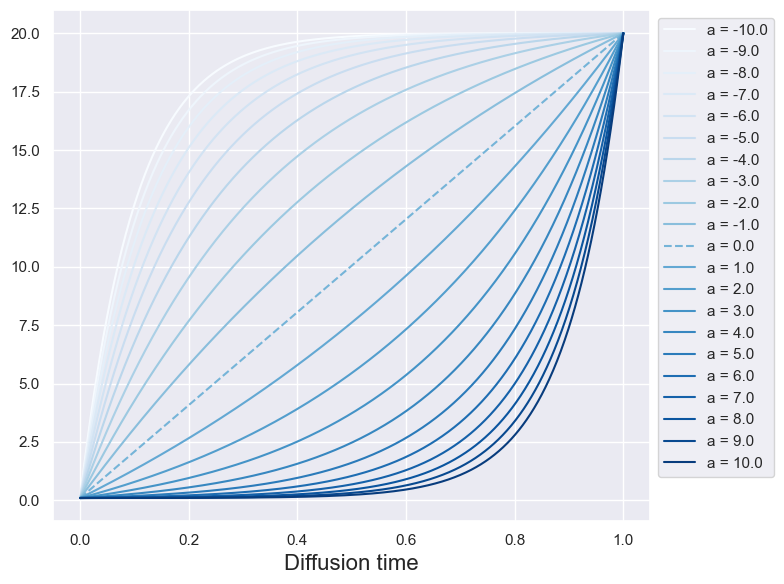

In [6]:
###
### NOISE SCHEDULE DISPLAY FOR beta_parametric
###
norm = mpl.colors.Normalize(vmin=0, vmax=len(a_values))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
colors = { a: cmap.to_rgba(k) for k, a in enumerate(a_values) }
colors

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 16
mpl.rcParams['lines.linewidth'] = 2

sns.set_theme()

fig, ax1 = plt.subplots(figsize=(8, 6), layout='tight')  

tt = torch.linspace(0, T, 1000)
for a in a_values:
    beta = diff.beta_parametric(a, T, beta_min, beta_max)
    color = colors[a]
    if a == 0:
        label = f"a = {a:.1f}"  # Custom label for a = 0
        line_style = '--'
        #color = 'red'
    else:
        label = f"a = {a}"
        line_style = '-'

    ax1.plot(tt, beta(tt), c=color, linestyle=line_style, label=label)

ax1.legend(bbox_to_anchor=(1, 1), loc="upper left")

ax1.set_xlabel('Diffusion time', fontsize=16)
#plt.savefig("fig/noising_functions.pdf")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

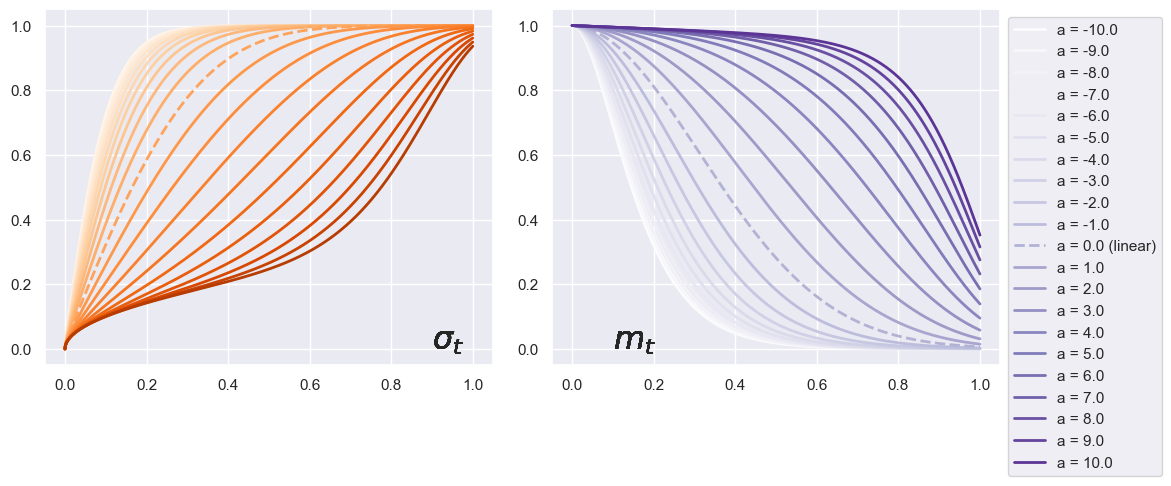

In [7]:
#
# FORWARD MEAN AND VARIANCE : MEAN mu_t AND SIGMA sigma_t for beta_parametric
#

norm = mpl.colors.Normalize(vmin=0, vmax=len(a_values)+3)
cmap1 = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Oranges)
colors1 = { a: cmap1.to_rgba(k) for k, a in enumerate(a_values) }
cmap2 = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Purples)
colors2 = { a: cmap2.to_rgba(k) for k, a in enumerate(a_values) }


mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 16
mpl.rcParams['lines.linewidth'] = 2

fig, (ax1, ax2) = plt.subplots(figsize=(12,5), ncols=2, layout='tight', sharex = True)
tt = torch.linspace(0, T, 1000)
for a in a_values:
    sde.beta.change_a(a)
    color1 = colors1[a]  
    color2 = colors2[a]
    if a == 0:
        label = f"a = {a:.1f} (linear)"
        line_style = '--'  
    else:
        label = f"a = {a}"
        line_style = '-'  


    ax1.plot(tt, sde.sigma(tt), c=color1, linestyle=line_style, label=label)
    ax1.text(0.9, 0, fr"$\sigma_t$", fontsize = 23)

    ax2.plot(tt, sde.mu(tt), c=color2, linestyle=line_style, label=label)
    ax2.text(0.1, 0, fr"$m_t$", fontsize = 23)

ax2.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.show

In [8]:
################################# SET SAMPLING PARAMETERS #################################
sample_batch_size = 10000
init = sde.final.generate_sample(sample_batch_size)
num_steps = 100 

In [9]:
##### EXACT SCORE SIMULATION GAUSSIAN CASE ####

xbarT_euler = sp.Euler_Maruyama_discr_sampler(init, sde, diff.explicit_score(sde, training_distribution), num_steps)
xbarT_semii = sp.EI_discr_sampler(init, sde, diff.explicit_score(sde, training_distribution), num_steps)

a_values = np.linspace(-10, 10, 21)
num_steps_vec = np.array([num_steps//4, num_steps//2, num_steps ]) #to adjust as desired
distances = []

for i, ns in tqdm(enumerate(num_steps_vec)):
    for j, a in enumerate(a_values):
        sde.beta.change_a(a)
        score_theta = diff.explicit_score(sde, training_distribution)
        for k, scheme in enumerate([sp.Euler_Maruyama_discr_sampler, sp.EI_discr_sampler]):
            sample = scheme(init, sde, score_theta, ns)
            distances.append({
                "a": a, "num_steps": ns, 
                "scheme": "euler" if k==0 else "semii", 
                "loss": "exact_score", 
                "kl": kl(training_distribution, empirical(sample)), 
                "w2": w2(training_distribution, empirical(sample)),
            })
distances_df = pd.DataFrame(distances)
df = distances_df 

3it [00:14,  4.91s/it]


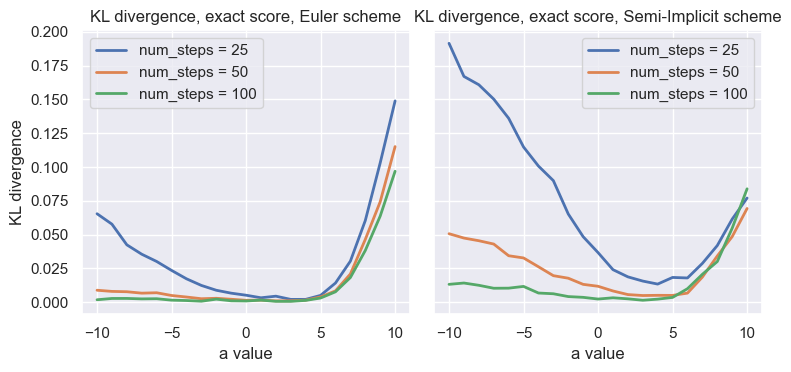

In [10]:
fig, axs = plt.subplots(figsize=(8,4), ncols=2, sharey=True, sharex = True)
axs[0].set_title("KL divergence, exact score, Euler scheme")
axs[1].set_title("KL divergence, exact score, Semi-Implicit scheme")

for k, scheme in enumerate(["euler", "semii"]):
    for ns in num_steps_vec:
        select = (df["scheme"] == scheme) & (df["loss"] == "exact_score") & (df["num_steps"]==ns)
        res_kl = df[select].groupby("a")["kl"].mean()
        axs[k].plot(a_values, res_kl, label=f"num_steps = {ns}")
    axs[k].legend()
    axs[k].set_xlabel("a value")

axs[0].set_ylabel("KL divergence")

plt.tight_layout()
plt.show()

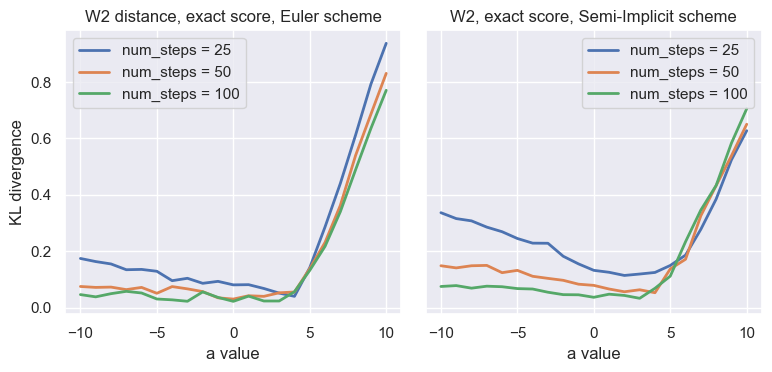

In [11]:
fig, axs = plt.subplots(figsize=(8,4), ncols=2, sharey=True, sharex = True)
axs[0].set_title("W2 distance, exact score, Euler scheme")
axs[1].set_title("W2, exact score, Semi-Implicit scheme")

for k, scheme in enumerate(["euler", "semii"]):
    for ns in num_steps_vec:
        select = (df["scheme"] == scheme) & (df["loss"] == "exact_score") & (df["num_steps"]==ns)
        res_kl = df[select].groupby("a")["w2"].mean()
        axs[k].plot(a_values, res_kl, label=f"num_steps = {ns}")
    axs[k].legend()
    axs[k].set_xlabel("a value")

axs[0].set_ylabel("KL divergence")

plt.tight_layout()
plt.show()

In [12]:
######## SELECT TRAINING PARAMETERS W.R.T THE DIMENSION ######################
if d==5: 
    # optimisation parameters
    n_epochs = 20 
    learning_rate = 1.0e-4
    
elif d==10: 
    # optimisation parameters
    n_epochs = 30
    learning_rate = 1.0e-4  
    
elif d==25: 
    # optimisation parameters
    n_epochs = 75
    learning_rate = 1.0e-3
    
elif d==50: 
    # optimisation parameters
    n_epochs = 150
    learning_rate = 1.0e-3

# network_parameters
mid_features = 256
num_layers = 3
batch_size = 64

# Monte Carlo estimate samples (for E2 computation in the KL bound)
num_mc = 500

# number of runs (for replication)
rep_size = 5

# load data
dataloader = DataLoader(training_sample, batch_size=batch_size, shuffle=True)

# number of discretisation steps
num_step = 100

In [13]:
%%time
###
## TRAINING NN FOR DIFFERENT NOISE SCHEDULES
###

score_theta_trained = [ [] for _ in a_values ]   # a_values, replicates
for k, a in enumerate(a_values):
    print(f"optimization for a = {a}")
    sde.beta.change_a(a)
    score_theta_trained[k] = [ ]
    for j in range(rep_size):
        network = decoder.Decoder(sde.d, mid_features, num_layers).to(device)
        optimizer = Adam(network.parameters(), lr=learning_rate)
        #loss = diff.loss_conditional(network, sde) # to choose when the score function is not analytically available
        loss = diff.loss_explicit(network, sde, diff.explicit_score(sde, training_distribution)) # to choose in the Gaussian case for training with the analytical score function
        diff.train(loss, dataloader, n_epochs=n_epochs, optimizer=optimizer)
        score_theta_trained[k].append(network)
        #torch.save(network.state_dict(), f'model/d'+str(d)+f'/model_{k}_{j}_d'+str(d)+'.pt')

'''
##### TO LOAD PRETRAINED MODELS
score_theta_trained = [ [] for _ in a_values ]   # a_values, replicates
for k, a in enumerate(a_values):
    score_theta_trained[k] = [ ]
    for j in range(rep_size):
        network = decoder.Decoder(sde.d, mid_features, num_layers) 
        network.load_state_dict(torch.load(f'model/d'+str(d)+f'/model_{k}_{j}_d'+str(d)+'.pt'))
        score_theta_trained[k].append(network)
'''

optimization for a = -10.0


Average Loss: 0.006856: 100%|███████████████████| 20/20 [00:04<00:00,  4.33it/s]


optimization for a = -9.0


Average Loss: 0.006464: 100%|███████████████████| 20/20 [00:04<00:00,  4.66it/s]


optimization for a = -8.0


Average Loss: 0.004817: 100%|███████████████████| 20/20 [00:04<00:00,  4.61it/s]


optimization for a = -7.0


Average Loss: 0.006005: 100%|███████████████████| 20/20 [00:04<00:00,  4.83it/s]


optimization for a = -6.0


Average Loss: 0.005601: 100%|███████████████████| 20/20 [00:05<00:00,  3.81it/s]


optimization for a = -5.0


Average Loss: 0.004666: 100%|███████████████████| 20/20 [00:04<00:00,  4.93it/s]


optimization for a = -4.0


Average Loss: 0.003981: 100%|███████████████████| 20/20 [00:04<00:00,  4.98it/s]


optimization for a = -3.0


Average Loss: 0.004458: 100%|███████████████████| 20/20 [00:04<00:00,  4.95it/s]


optimization for a = -2.0


Average Loss: 0.003701: 100%|███████████████████| 20/20 [00:04<00:00,  4.86it/s]


optimization for a = -1.0


Average Loss: 0.003216: 100%|███████████████████| 20/20 [00:04<00:00,  4.96it/s]


optimization for a = 0.0


Average Loss: 0.002898: 100%|███████████████████| 20/20 [00:03<00:00,  5.10it/s]


optimization for a = 1.0


Average Loss: 0.002781: 100%|███████████████████| 20/20 [00:04<00:00,  4.95it/s]


optimization for a = 2.0


Average Loss: 0.002536: 100%|███████████████████| 20/20 [00:04<00:00,  4.91it/s]


optimization for a = 3.0


Average Loss: 0.002838: 100%|███████████████████| 20/20 [00:04<00:00,  4.93it/s]


optimization for a = 4.0


Average Loss: 0.002770: 100%|███████████████████| 20/20 [00:04<00:00,  4.87it/s]


optimization for a = 5.0


Average Loss: 0.003141: 100%|███████████████████| 20/20 [00:04<00:00,  4.78it/s]


optimization for a = 6.0


Average Loss: 0.002800: 100%|███████████████████| 20/20 [00:04<00:00,  4.96it/s]


optimization for a = 7.0


Average Loss: 0.003253: 100%|███████████████████| 20/20 [00:04<00:00,  4.99it/s]


optimization for a = 8.0


Average Loss: 0.003403: 100%|███████████████████| 20/20 [00:04<00:00,  4.71it/s]


optimization for a = 9.0


Average Loss: 0.003381: 100%|███████████████████| 20/20 [00:04<00:00,  4.28it/s]


optimization for a = 10.0


Average Loss: 0.004224: 100%|███████████████████| 20/20 [00:04<00:00,  4.84it/s]

CPU times: user 24min 40s, sys: 31min 49s, total: 56min 30s
Wall time: 7min 23s


"\n##### TO LOAD PRETRAINED MODELS\nscore_theta_trained = [ [] for _ in a_values ]   # a_values, replicates\nfor k, a in enumerate(a_values):\n    score_theta_trained[k] = [ ]\n    for j in range(rep_size):\n        network = decoder.Decoder(sde.d, mid_features, num_layers) \n        network.load_state_dict(torch.load(f'model/d'+str(d)+f'/model_{k}_{j}_d'+str(d)+'.pt'))\n        score_theta_trained[k].append(network)\n"

In [14]:
### GAUSSIAN CASE

simulation_results = []

for k, a in tqdm(enumerate(a_values)):
    print(f"simulation and M for a = {a}")
    sde.beta.change_a(a)
    exp_score = diff.explicit_score(sde, training_distribution)

    for j, score_theta in enumerate(score_theta_trained[k]):
        error_approx_E2, error_approx_sup_L2 = up.compute_E2(training_distribution, sde, score_theta, exp_score, num_steps, num_mc) ##### CHANGE

        for scheme_name, scheme_sampler in [("euler", sp.Euler_Maruyama_discr_sampler), ("semii", sp.EI_discr_sampler)]:
            sample = scheme_sampler(init, sde, score_theta, num_steps)
            kl_value = kl(training_distribution, empirical(sample))
            w2_value = w2(training_distribution, empirical(sample))

            simulation_results.append({
                "a": a,
                "replication": j,
                "scheme": scheme_name,
                "error_approx_E2": error_approx_E2,
                "error_approx_sup_L2": error_approx_sup_L2,
                "kl": kl_value,
                "w2": w2_value,
            })

simulation_df = pd.DataFrame(simulation_results)

0it [00:00, ?it/s]

simulation and M for a = -10.0


1it [00:10, 10.84s/it]

simulation and M for a = -9.0


2it [00:22, 11.16s/it]

simulation and M for a = -8.0


3it [00:32, 10.98s/it]

simulation and M for a = -7.0


4it [00:43, 10.92s/it]

simulation and M for a = -6.0


5it [00:54, 10.70s/it]

simulation and M for a = -5.0


6it [01:05, 10.78s/it]

simulation and M for a = -4.0


7it [01:15, 10.79s/it]

simulation and M for a = -3.0


8it [01:27, 10.93s/it]

simulation and M for a = -2.0


9it [01:38, 11.20s/it]

simulation and M for a = -1.0


10it [01:50, 11.23s/it]

simulation and M for a = 0.0


11it [02:00, 10.96s/it]

simulation and M for a = 1.0


12it [02:11, 10.85s/it]

simulation and M for a = 2.0


13it [02:21, 10.83s/it]

simulation and M for a = 3.0


14it [02:32, 10.78s/it]

simulation and M for a = 4.0


15it [02:43, 10.72s/it]

simulation and M for a = 5.0


16it [02:53, 10.63s/it]

simulation and M for a = 6.0


17it [03:05, 10.93s/it]

simulation and M for a = 7.0


18it [03:15, 10.88s/it]

simulation and M for a = 8.0


19it [03:27, 10.94s/it]

simulation and M for a = 9.0


20it [03:37, 10.83s/it]

simulation and M for a = 10.0


21it [03:48, 10.86s/it]


In [15]:
epsilon = simulation_df.groupby('a')['error_approx_sup_L2'].mean()
error_results = []

for k, a in tqdm(enumerate(a_values)):
    print(f"bound for a = {a}")
    sde.beta.change_a(a)
    
    error_mixing_E1 = up.compute_E1(training_distribution, sde)
    error_discr_E3 = up.compute_E3(training_distribution, sde, num_steps)
    w2_error = up.compute_w2_bound(training_distribution, training_sample, sde, num_steps, epsilon[a])
    
    error_results.append({
        "a": a,
        "error_mixing_E1": error_mixing_E1,
        "error_discr_E3":  error_discr_E3,
        "w2_error": w2_error
    })

errors_df = pd.DataFrame(error_results)

0it [00:00, ?it/s]

bound for a = -10.0


1it [00:00,  1.39it/s]

bound for a = -9.0


2it [00:01,  1.41it/s]

bound for a = -8.0


3it [00:02,  1.40it/s]

bound for a = -7.0


4it [00:02,  1.39it/s]

bound for a = -6.0


5it [00:03,  1.40it/s]

bound for a = -5.0


6it [00:04,  1.40it/s]

bound for a = -4.0


7it [00:05,  1.40it/s]

bound for a = -3.0


8it [00:05,  1.39it/s]

bound for a = -2.0


9it [00:06,  1.39it/s]

bound for a = -1.0


10it [00:07,  1.40it/s]

bound for a = 0.0


11it [00:07,  1.50it/s]

bound for a = 1.0


12it [00:08,  1.47it/s]

bound for a = 2.0


13it [00:09,  1.44it/s]

bound for a = 3.0


14it [00:09,  1.43it/s]

bound for a = 4.0


15it [00:10,  1.42it/s]

bound for a = 5.0


16it [00:11,  1.41it/s]

bound for a = 6.0


17it [00:12,  1.41it/s]

bound for a = 7.0


18it [00:12,  1.41it/s]

bound for a = 8.0


19it [00:13,  1.41it/s]

bound for a = 9.0


20it [00:14,  1.41it/s]

bound for a = 10.0


21it [00:14,  1.41it/s]


In [16]:
results_df = pd.merge(simulation_df, errors_df, on="a", how="left")

# comutation of the upperbound KL
error_mixing_E1 = results_df.groupby('a')['error_mixing_E1'].first()
error_approx_E2 = results_df.groupby('a')['error_approx_E2'].mean()
error_discr_E3 = results_df.groupby('a')['error_discr_E3'].first()
KL_upperbound = error_mixing_E1 + error_approx_E2 + error_discr_E3

# comutation of the upperbound W2
W2_upperbound = results_df.groupby('a')['w2_error'].mean()


# generation results KL 
mean_all_Euler_KL = results_df[results_df['scheme'] == 'euler'].groupby('a')['kl'].mean()
std_all_Euler_KL = results_df[results_df['scheme'] == 'euler'].groupby('a')['kl'].std()
mean_all_EI_KL = results_df[results_df['scheme'] == 'semii'].groupby('a')['kl'].mean()
std_all_EI_KL = results_df[results_df['scheme'] == 'semii'].groupby('a')['kl'].std()

# generation results W2 
mean_all_Euler_W2 = results_df[results_df['scheme'] == 'euler'].groupby('a')['w2'].mean()
std_all_Euler_W2 = results_df[results_df['scheme'] == 'euler'].groupby('a')['w2'].std()
mean_all_EI_W2 = results_df[results_df['scheme'] == 'semii'].groupby('a')['w2'].mean()
std_all_EI_W2 = results_df[results_df['scheme'] == 'semii'].groupby('a')['w2'].std()

# generation results VPSDE KL

VPSDE_mean_KL = mean_all_Euler_KL[0.0]
VPSDE_std_KL = std_all_Euler_KL[0.0]

# generation results VPSDE W2

VPSDE_mean_W2 = mean_all_Euler_W2[0.0]
VPSDE_std_W2 = std_all_Euler_W2[0.0]

# Exact score results KL 
true_score_KL_Euler = df[(df["scheme"] == 'euler') & (df["loss"] == "exact_score") & (df["num_steps"]==num_steps)]['kl']
true_score_KL_EI = df[(df["scheme"] == 'semii') & (df["loss"] == "exact_score") & (df["num_steps"]==num_steps)]['kl']

# Exact score results W2 
true_score_W2_Euler = df[(df["scheme"] == 'euler') & (df["loss"] == "exact_score") & (df["num_steps"]==num_steps)]['w2']
true_score_W2_EI = df[(df["scheme"] == 'semii') & (df["loss"] == "exact_score") & (df["num_steps"]==num_steps)]['w2']

/var/folders/9z/qx8447gj5cb1fgysfwh3gc340000gn/T/ipykernel_7450/244944466.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')


KL EULER


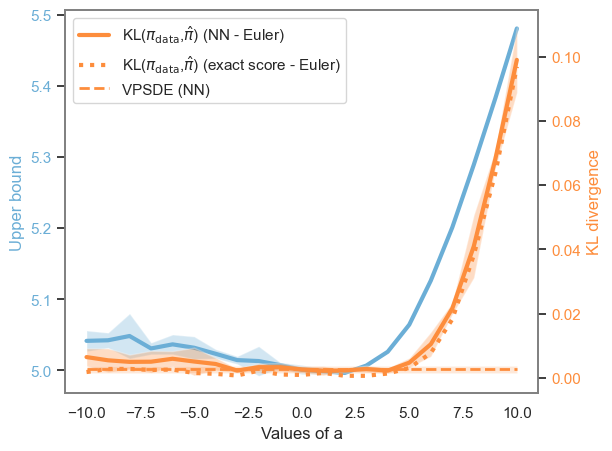

In [17]:
##### PLOT KL VS##### PLOT KL VS BOUND

print("KL EULER")

font = {'family' : 'sans-serif',
        'size'   : 16}
plt.rc('font', **font)
cmap = cm.get_cmap('tab20c')
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'gray'

fig, ax1 = plt.subplots()

y1_color = cmap(1/20)
ax1.plot(a_values, KL_upperbound, color=y1_color, label="Upper-bound",linewidth=3)
ax1.fill_between(a_values,
                 ([x.item() for x in KL_upperbound]) - results_df.groupby('a')['error_approx_E2'].std().to_numpy() ,
                 ([x.item() for x in KL_upperbound]) + results_df.groupby('a')['error_approx_E2'].std().to_numpy() ,
                 fc=y1_color,alpha=.3)
ax1.set_xlabel("Values of a")
ax1.set_ylabel("Upper bound", color=y1_color)
ax1.tick_params(axis='y', labelcolor=y1_color)

y2_color = cmap(5/20)
y3_color = cmap(5/20)
color_0 = 'gray' #mean_all_Euler_KL
color_bis = 'black'
ax2 = ax1.twinx()

ax2.plot(a_values, mean_all_Euler_KL, color=y2_color, label="KL($\\pi_{\\rm data}$,$\\hat{\\pi}$) (NN - Euler) ",linewidth=3)
ax2.plot(a_values, true_score_KL_Euler, color=y2_color, label = "KL($\\pi_{\\rm data}$,$\\hat{\pi}$) (exact score - Euler)",linewidth=3, linestyle='dotted')
ax2.fill_between(a_values,
                 mean_all_Euler_KL-std_all_Euler_KL,
                 mean_all_Euler_KL+std_all_Euler_KL,
                 fc=y2_color,alpha=.3)
ax2.plot(a_values, np.full_like(a_values, VPSDE_mean_KL), color=y3_color, label="VPSDE (NN)",linewidth=2, linestyle='--')
ax2.fill_between(a_values,
                 VPSDE_mean_KL-VPSDE_std_KL,
                 VPSDE_mean_KL+VPSDE_std_KL,
                 fc=y3_color,alpha=.2)
ax2.set_ylabel("KL divergence", color=y2_color)
ax2.tick_params(axis='y', labelcolor=y2_color)

fig.tight_layout()
plt.legend()
plt.show() 

W2 EULER


/var/folders/9z/qx8447gj5cb1fgysfwh3gc340000gn/T/ipykernel_7450/2544229921.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')


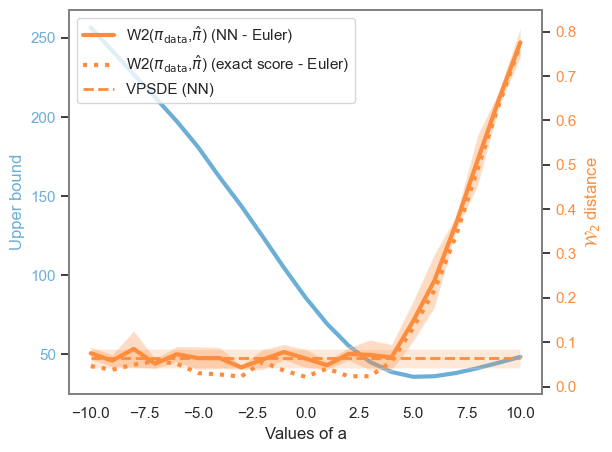

In [18]:
print("W2 EULER")

font = {'family' : 'sans-serif',
        'size'   : 16}
plt.rc('font', **font)
cmap = cm.get_cmap('tab20c')
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'gray'

fig, ax1 = plt.subplots()

y1_color = cmap(1/20)
ax1.plot(a_values, W2_upperbound, color=y1_color, label="Upper-bound",linewidth=3 )
#ax1.fill_between(a_values,
#                 ([x.item() for x in KL_upperbound]) - results_df.groupby('a')['error_approx_E2'].std().to_numpy() ,
#                 ([x.item() for x in KL_upperbound]) + results_df.groupby('a')['error_approx_E2'].std().to_numpy() ,
#                 fc=y1_color,alpha=.3)
ax1.set_xlabel("Values of a")
ax1.set_ylabel("Upper bound", color=y1_color)
ax1.tick_params(axis='y', labelcolor=y1_color)
#ax1.set_ylim(0,300)

y2_color = cmap(5/20)
y3_color = cmap(5/20)
color_0 = 'gray' 
color_bis = 'black'
ax2 = ax1.twinx()

ax2.plot(a_values, mean_all_Euler_W2, color=y2_color, label="W2($\\pi_{\\rm data}$,$\\hat{\\pi}$) (NN - Euler) ",linewidth=3)
ax2.plot(a_values, true_score_W2_Euler, color=y2_color, label = "W2($\\pi_{\\rm data}$,$\\hat{\pi}$) (exact score - Euler)",linewidth=3, linestyle='dotted')
ax2.fill_between(a_values,
                 mean_all_Euler_W2-std_all_Euler_W2,
                 mean_all_Euler_W2+std_all_Euler_W2,
                 fc=y2_color,alpha=.3)
ax2.plot(a_values, np.full_like(a_values, VPSDE_mean_W2), color=y3_color, label="VPSDE (NN)",linewidth=2, linestyle='--')
ax2.fill_between(a_values,
                 VPSDE_mean_W2-VPSDE_std_W2,
                 VPSDE_mean_W2+VPSDE_std_W2,
                 fc=y3_color,alpha=.2)
ax2.set_ylabel(r"$\mathcal{W}_2$ distance", color=y2_color)
ax2.tick_params(axis='y', labelcolor=y2_color)

fig.tight_layout()
plt.legend()
plt.show() 

In [19]:
print("Recap of the parameters used:")
print("------------------------------------------------")
print("{:<30} | {:<15}".format('Parameter', 'Value'))
print("------------------------------------------------")
parameters = ["Number of discretisation Steps", "Sample batch size", "Training batch size",
              "Epochs", "Learning rate",  "Number of layers", "Number of neurones per layer", 'Number of runs', 'Number of MC it for E2']
values = [num_steps, sample_batch_size, batch_size, n_epochs, learning_rate,  num_layers, mid_features, rep_size, num_mc]

for param, value in zip(parameters, values):
    print(f"{param:<30} | {value:<15}")

print("------------------------------------------------")

Recap of the parameters used:
------------------------------------------------
Parameter                      | Value          
------------------------------------------------
Number of discretisation Steps | 100            
Sample batch size              | 10000          
Training batch size            | 64             
Epochs                         | 20             
Learning rate                  | 0.0001         
Number of layers               | 3              
Number of neurones per layer   | 256            
Number of runs                 | 5              
Number of MC it for E2         | 500            
------------------------------------------------


In [20]:
print("Recap of the training data and noising function:")
print("------------------------------------------------")

Training_data_val = ["Dimension", "Target mean ",  "Stationnary distribution forward", "Diffusion time"]
training_values = [sde.d, str(training_distribution._mu) , sde.sigma_infty, sde.final_time]

for param, value in zip(Training_data_val, training_values):
    print(f"{param:<32} | {value:<15}")

Recap of the training data and noising function:
------------------------------------------------
Dimension                        | 5              
Target mean                      | tensor([1., 1., 1., 1., 1.])
Stationnary distribution forward | 1              
Diffusion time                   | 1              
